In [ ]:
#!jupyter nbconvert --to=python DFe_PISCES_Comparison_python3.ipynb

# After changes in the script using Jupyter notebook, save the notebook, run this line, and clear the output.

In [15]:
class DFecomp:
    '''
    class DFecomp(runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 PISCESvar='Fe',mapproj='pc',savefig=False,layerwise=False)
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 PISCESvar='Fe',
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.ncpath = ncpath
        self.fyear = first_year
        self.lyear = last_year
        self.PISCESvar = PISCESvar
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array

        import matplotlib.pyplot as plt
        import numpy as np
        from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf

        from plot_Taylor_normalized import plt_Taylor_norm

        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(meshpath)
        years = [self.fyear, self.lyear]

        # check variables
        #NCfesom = self.resultpath + '/DFe.'+self.runname+'.'+str(self.fyear)+'.nc'
        #!ncdump -h $NCfesom

        labelfesom = 'FESOM DFe {0}-{1}'.format(self.fyear,self.lyear)
        unitfesom = 'DFe [mmol m$^{-3}$]' # equals to mumol/L

        # load FESOM data -------------------------------------------------------------------------------------
        DFefesom = pf.get_data(resultpath, "DFe", years, mesh, 
                               how="mean", compute=True, runid=self.runname, silent=True)

        # load FESOM mesh diag -------------------------------------------------------------------------------
        meshdiag= self.resultpath+'/'+self.runname+'.mesh.diag.nc'
        #!ncdump -h $meshdiag

        diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=self.runname)
        #print(diag)
        #print(diag['Z']) # depth of layers
        mesh_depths = diag['Z'].values
        
        # load raw PISCES data -------------------------------------------------------------------------------------

        f          = Dataset(self.ncpath, 'r')
        DepthRaw   = -f.variables['DEPTH'][:]                                # Depth is negative
        DFe        =  f.variables[self.PISCESvar][:]                         # Unit [mol/L]
        DFe        = 1.e9 * DFe                                              # [mol/L] => [umol/m3] 
        DFe        = np.ma.filled(DFe, np.nan)                               # From masked array to numpy array

        DFeRaw     = np.zeros(shape=(np.shape(DFe)))                         # Change longitude from 0:360 to -180:180 
        for i in range(0,len(DepthRaw)):
          DFeRaw[i,:,:] = np.hstack((DFe[i,:,181:360],DFe[i,:,0:181]))

        x360       = np.arange(-179.5,180.,1.)
        y180       = np.arange(-89.5,89.6,1.)
        X360, Y180 = np.meshgrid(x360, y180)
        
        labelpisces = 'PISCES DFe'
        unitpisces = 'DFe [mmol m$^{-3}$]'
        
        # interpolate PISCES data -------------------------------------------------------------------------------------

        # check maximum depth in PISCES compared to FESOM
        dmin_woa = np.min(DepthRaw)
        dmin_fesom = np.min(mesh_depths)

        if(dmin_woa <= dmin_fesom):
            print('***\nDepth greater in PISCES ({0}) than in FESOM ({1})'.format(dmin_woa, dmin_fesom))
            ilev = len(mesh_depths)
            max_zlev = mesh_depths[ilev-1]
        else:
            print('***\nDepth greater in FESOM ({1}) than in PISCES ({0})'.format(dmin_woa, dmin_fesom))
            ilev = np.where(mesh_depths >= dmin_woa)
            ilev = ilev[0][-1]
            max_zlev = mesh_depths[ilev]

        print('Please consider choosing max depth level {0} with max depth at {1}!\n***'.format(ilev,max_zlev))
    

        # storage container
        pisces_int = np.zeros((len(mesh_depths),len(mesh.x2)))
        #print(np.shape(din_int))

        for k in range(0,len(mesh_depths)): # layer depth as in meshi diag.Z
            lev = mesh_depths[k] # current FESOM depth
            ind1 = np.where(DepthRaw >= lev)
            ind1 = ind1[0][-1]
            ind2 = np.where(DepthRaw < lev)[0]

            if ind2.size > 0:                            # If we have not yet reached the bottom
                ind2 = ind2[0]                           # The index of the depth level below the current fesom level
                c    = DepthRaw[ind1]-DepthRaw[ind2]     # Difference in depth between the data value above and below the fesom depth
                c1   = DepthRaw[ind1]-lev                # Difference between fesom depth and data depth above
                c2   = -(DepthRaw[ind2]-lev)             # Difference between fesom depth and data depth below
                c1   = (c-c1)/c                          # Scaling coefficient for the depth above
                c2   = (c-c2)/c                          # Scaling coefficient for the depth below
            else:                                        # We have reached the bottom
                c1   = 1.
                c2   = 0.
                ind2 = ind1

            indZ  = np.where(mesh_depths == lev)                               
            # original code:
            # indZ  = np.where(-mesh.z3 == lev)          # Find the mesh index of the current fesom depth
            indZ = indZ[0] 
            if(False):
                print('\nFESOM depth = {0}, WOA depths = {1}, {2} \nDepth indices: {3} {4},  FESOM index: {5} \nScaling c1 = {6}, c2 = {7}'.format(lev,DepthRaw[ind1],DepthRaw[ind2],ind1, ind2,indZ,c1,c2))


            aux1  = DFeRaw[ind1,:,:]                     # Find the data above the current fesom depth
            aux2  = DFeRaw[ind2,:,:]                     # Find the data below the current fesom depth
            aux   = np.squeeze(c1*aux1+c2*aux2)          # Scaling the data according to vertical distribution as found above
            ind   = np.squeeze(~np.isnan(aux)) 
            #print(np.shape(aux), np.shape(ind))

            # first interpolation to original grid to close empty parts
            aux = griddata((X360[ind], Y180[ind]), aux[ind], (X360, Y180), method='nearest')                             
            # 2D field without nans                           

            # second interpolation to FESOM grid
            pisces_int[indZ,:] = griddata((X360.ravel(), Y180.ravel()), aux.ravel(), 
                                   (mesh.x2, mesh.y2), method='nearest')  
            # Final interpolated field

            if np.isnan(np.min(pisces_int)): print('WARNING: The interpolated field contains NaNs at depth',lev)                 # Testing if results contain NaNs. If yes, the routine needs adjustments

            if(False):
                print('Depth: {0} min = {1} max = {2} mean = {3}'.format(lev,np.min(pisces_int), np.max(pisces_int), np.mean(pisces_int)))

        pisces_int = np.swapaxes(pisces_int,0,1) # adjust axes layout to FESOM output
        

        # apply sea mask to PISCES as in FESOM ----------------------------------------------------------------------------------
        # assumption: there is no ocean where value in FESOM == 0
        pisces_int_ma = np.copy(pisces_int)
        pisces_int_ma[DFefesom == 0] = 0

        # plot PISCES and FESOM ----------------------------------------------------------------------------------
        if(self.layerwise):
            if(self.depth_array == []):
                depth_array = (0,50,200,1000,2000,4000)

            for d in depth_array:
                # get mesh index closest to desired depth
                i = pf.ind_for_depth(d,mesh) 
                # get midlevel depth
                plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

                if(True):
                    print('\nInput depth = {0}, plotting at depth = {1} m\nFESOM min = {2}, max = {3}\nPISCES min = {4}, max = {5}'.format(
                        d,plot_depth,
                        np.nanmin(DFefesom[:,i]),np.nanmax(DFefesom[:,i]),
                        np.nanmin(pisces_int_ma[:,i]),np.nanmax(pisces_int_ma[:,i])))

                pf.plot(mesh, [pisces_int_ma[:,i],DFefesom[:,i], pisces_int_ma[:,i]-DFefesom[:,i]], 
                        rowscol= (1,3),
                        #levels = (0,45,40),
                        units=unitpisces + '\n at depth = {0} m'.format(plot_depth), 
                        mapproj=self.mapproj, # robinson projection takes more time!
                        titles=[labelpisces, labelfesom, 'PISCES - FESOM'],figsize = (20,20)
                       )

            # statistics  -------------------------------------------------------------------------------------
            # preparation of datasets
            if np.isnan(np.min(pisces_int)): print('WARNING: The interpolated PISCES field contains NaNs at depth')
            if np.isnan(np.min(DFefesom)): print('WARNING: The interpolated FESOM field contains NaNs at depth')


            for d in depth_array:
                # get mesh index closest to desired depth
                i = pf.ind_for_depth(d,mesh) 
                # get midlevel depth
                plot_depth = str((mesh.zlev[i]+mesh.zlev[i+1])/2)

                title = 'Taylor Diagram for DFe at {0} m'.format(plot_depth)
                plt_Taylor_norm(pisces_int[i],DFefesom[i],mask=True,title=title)
                
                if False: #old
                    # get statistics only from ocean gridpoints (same mask assumption as above)
                    ind_stat = np.where(DFefesom[i,:] != 0)

                    taylor_stats1 = sm.taylor_statistics(pisces_int[i,ind_stat],DFefesom[i,ind_stat])
                    sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
                    crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
                    ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])

                    label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

                    fig = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
                    sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                                          titleOBS = 'observation', markerLabel = label,
                                          markerLabelColor = 'c',
                                          markerColor = 'c', markerLegend = 'on',
                                          tickRMS = range(0,5,1), tickRMSangle = 135.0,
                                          colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                                          titleRMS = 'off', tickSTD = range(0,10,2 ),
                                          axismax = 10.0, 
                                          colSTD = 'b', styleSTD = '-.',
                                          widthSTD = 1.0, titleSTD = 'on',
                                          colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                                          titleCOR = 'on')
                    plt.title('Taylor Diagram for DFe at {0} m'.format(plot_depth), loc='right')
        
            if(self.savefig==True): print('\n***\n***Too many figures to export...\n***')
        
        # mean over depth  -------------------------------------------------------------------------------------
        else:
            
            DFefesom_mean = np.mean(DFefesom, axis = 1)
            pisces_int_ma_mean = np.mean(pisces_int_ma, axis = 1)
            #print(np.shape(DFefesom_mean), np.shape(pisces_int_ma_mean))

            print('\nPlotting DFe as mean over depth\nFESOM min = {0}, max = {1}\nPISCES min = {2}, max = {3}'.format(
                    np.nanmin(DFefesom_mean),np.nanmax(DFefesom_mean),
                    np.nanmin(pisces_int_ma_mean),np.nanmax(pisces_int_ma_mean)))
    
            fig_data = pf.plot(mesh, [pisces_int_ma_mean,DFefesom_mean, pisces_int_ma_mean-DFefesom_mean], 
                    rowscol= (3,1),
                    #levels = (0,35,36),
                    units=unitpisces, 
                    mapproj=self.mapproj, # robinson projection takes more time!
                    titles=['PISCES: Interpolated DFe for initialization', 
                            'FESOM DFe ({0}-{1})'.format(first_year,last_year),
                            'Initialization fields minus FESOM'],
                    figsize = (20,20)
                   )
            # fig export  -------------------------------------------------------------------------------------
            if(self.savefig==True):
                plt.savefig(self.savepath+self.runname+'_'+'DFE_PISCES'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False)  
                
            # statistics  -------------------------------------------------------------------------------------            
            # preparation of datasets
            if np.isnan(np.min(pisces_int_ma_mean)): print('WARNING: The interpolated PISCES field contains NaNs at depth')
            if np.isnan(np.min(DFefesom_mean)): print('WARNING: The interpolated FESOM field contains NaNs at depth')

            title = 'Taylor Diagram for DFe \n(mean over depth)'
            plt_Taylor_norm(pisces_int_ma_mean,DFefesom_mean,mask=True,title=title)
            
            if False: #old
                # get statistics only from ocean gridpoints (same mask assumption as above)
                ind_stat = np.where(DFefesom_mean != 0)

                taylor_stats1 = sm.taylor_statistics(pisces_int_ma_mean[ind_stat],DFefesom_mean[ind_stat])
                sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
                crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
                ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])

                label = ['Observation', 'Model']# at {0} m'.format(plot_depth)]

                fig_stat = plt.figure(figsize=(7,7), facecolor='w', edgecolor='k')
                sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
                                      titleOBS = 'observation', markerLabel = label,
                                      markerLabelColor = 'c',
                                      markerColor = 'c', markerLegend = 'on',
                                      #tickRMS = range(0,5,1), 
                                      #tickRMSangle = 135.0,
                                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                                      titleRMS = 'off', #tickSTD = range(0,10,2 ),
                                      #axismax = 10.0, 
                                      colSTD = 'b', styleSTD = '-.',
                                      widthSTD = 1.0, titleSTD = 'on',
                                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                                      titleCOR = 'on')
                plt.title('Taylor Diagram for DFe \n(mean over depth)', loc='right')  
                
            # fig export  -------------------------------------------------------------------------------------
            if(self.savefig==True):                
                plt.savefig(self.savepath+self.runname+'_'+'DFe_PISCES_Taylor'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False)  
        

***
Depth greater in FESOM (-6125.0) than in PISCES (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DFe as mean over depth
FESOM min = 0.004167595878243446, max = 729641.875
PISCES min = 0.0013974910562342786, max = 3208849.386462709


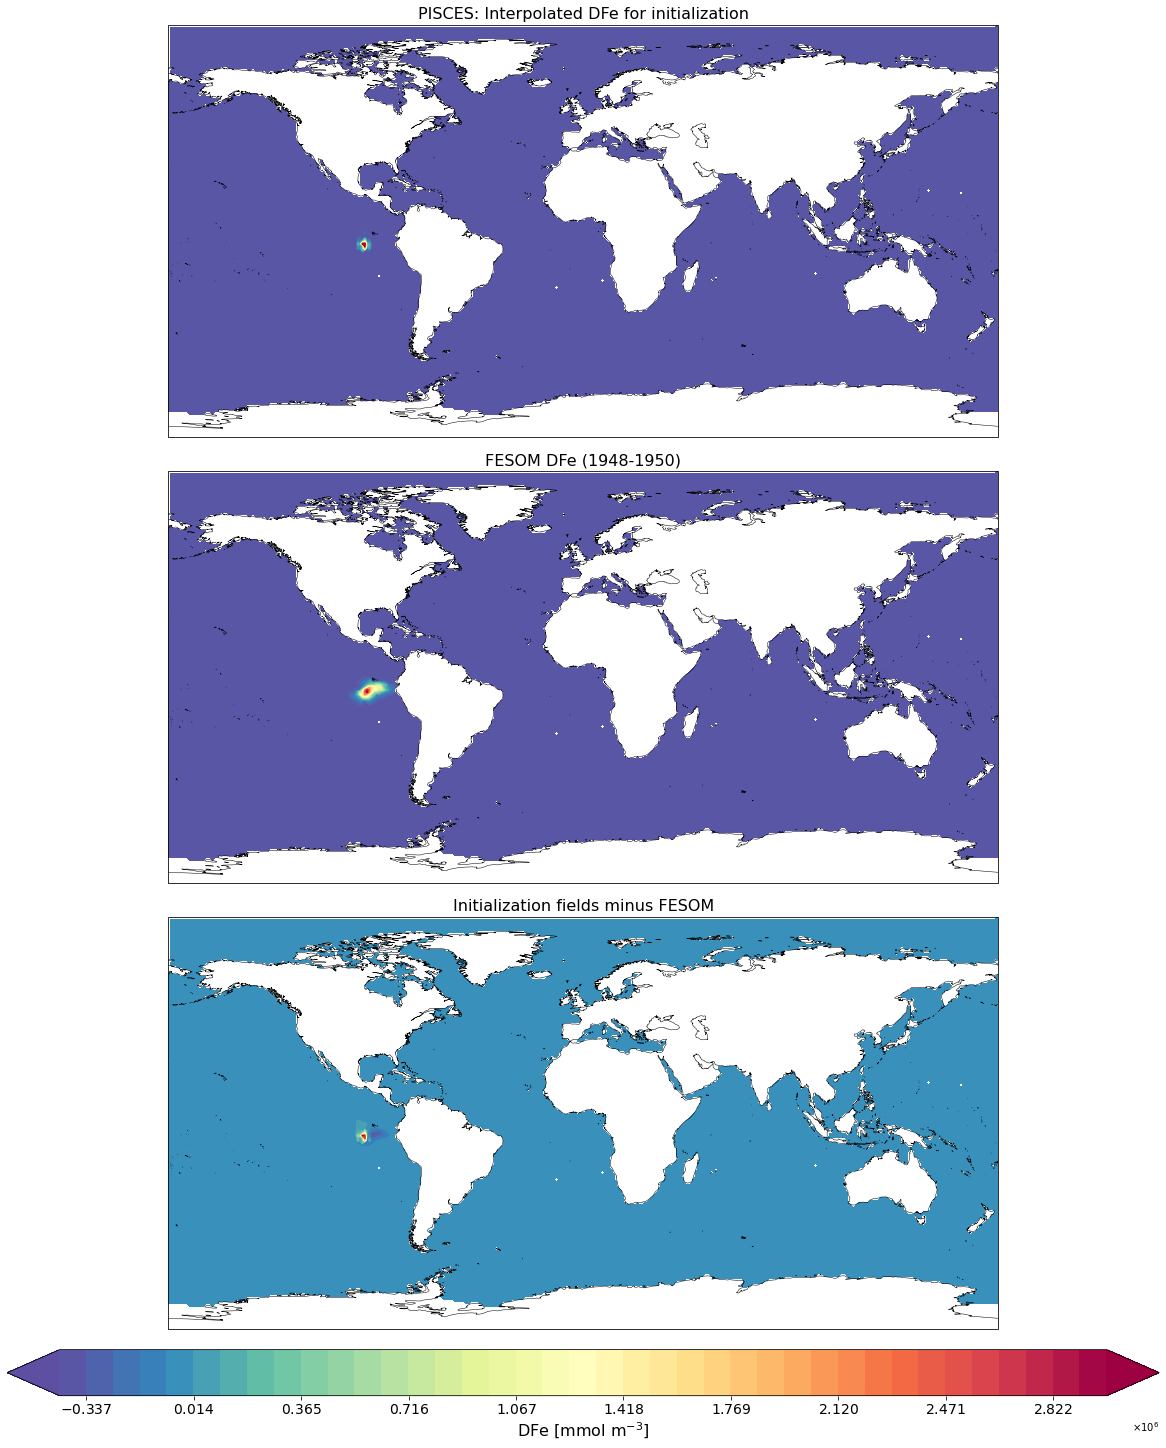

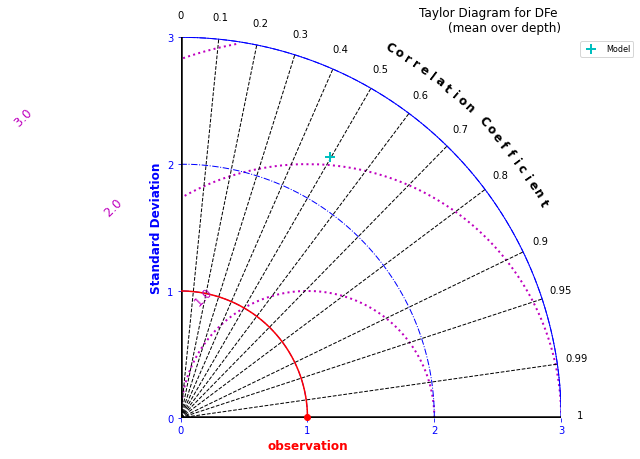

In [16]:
### TESTING ###
if __name__ == "__main__":
    
    # run specification -------------------------------------------------------------------------------------
    runid      =  'mo1'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    htmlname     =  runid + '.html'
    htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    #modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
    #modulepath   = '/home/ollie/jhauck/py_fesom/modules/'

    #obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # period of analysis ------------------------------------------------------------------------------------

    first_year = 1948
    last_year  = 1950

    # WOA ------------------------------------------------------------------------------------    
    ncfileDFe                = '/work/ollie/projects/MarESys/evaluation/fe_pisces_opa_eq_init_3D.nc' 
    ncpath = ncfileDFe
    #!ncdump -h $ncpath
    
    # now test:
    test = DFecomp(runid,resultpath,savepath,meshpath,ncpath,first_year,last_year,layerwise=False,savefig=False)